### Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:

* id: id univoco dell'acquirente.
* Gender: sesso dell'acquirente.
* Age: età dell'acquirente.
* Driving_License: 1 se l'utente ha la patente di guida, 0 altrimenti.
* Region_Code: codice univoco della regione dell'acquirente.
* Previously_Insured: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
* Vehicle_Age: età del veicolo
* Vehicle_Damage: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
* Annual_Premium: la cifra che l'utente deve pagare come premio durante l'anno.
* Policy_Sales_Channel: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
* Vintage: numero di giorni dalla quale l'utente è cliente dell'azienda.
* Response: 1 se l'acquirente ha risposto positivamente alla proposta di vendita, 0 altrimenti.


L'obiettivo del modello è prevedere il valore di Response.

Tip Fai attenzione alla distribuzione delle classi, dai uno sguardo a questo approfondimento (https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). In caso di classi sbilanciate puoi provare a:

Penalizzare la classe più frequente (ricorda l'argomento class_weight)
Utilizzare l'oversampling o l'undersampling (https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/). 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv("../datasets/insurance_cross_sell.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Analizzo le statistiche del Dataframe

In [6]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [8]:
#Shape of data
df.shape

(381109, 12)

## Controllo se ci sono dati nulli

In [34]:
#checking missing values
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Il dataset non ha valori nulli.

In [10]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

## Controllo se ci sono duplicati

In [11]:
display(df.drop_duplicates())

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## Visualizziamo i dati relativi alla feature "Response"

<Axes: xlabel='Response', ylabel='count'>

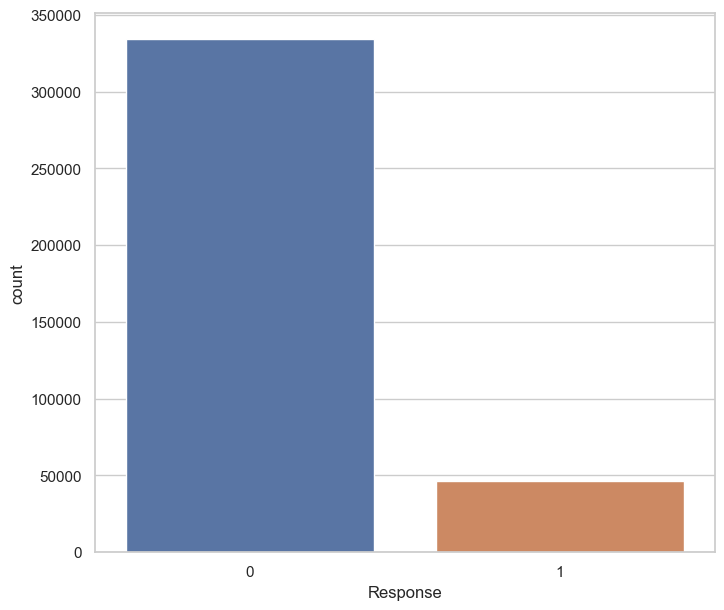

In [12]:
plt.figure(figsize=(8,7))
sns.set_theme(style='whitegrid')
sns.countplot(x=df['Response'],data=df)

Possiamo notare dal grafico che i dati sono altamente sbilanciati

# Encoding

## Convertiamo le variabili categoriche Gender, Vehicle_Age e Veichle_Damage in variabili numeriche

In [13]:
df['Gender'] = df['Gender'].map({'Female':1, 'Male':0})
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [14]:
df['Vehicle_Age']= df['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,2,Yes,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,No,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2,Yes,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,No,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,No,27496.0,152.0,39,0


In [15]:
df['Vehicle_Damage']=df['Vehicle_Damage'].map({'Yes':1, 'No':0})
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


## Escludo dal dataset le features non rilevanti

In [17]:
X=df.drop(columns=['id','Response'])
y = df['Response']

## Sostituisco i valori mancanti nei dati numerici con la moda di ciascuna colonna

In [ ]:
fill_mode = lambda col: col.fillna(col.mode())
X = X.apply(fill_mode, axis=0)
df = df.apply(fill_mode, axis=0)

# Costruzione del modello

## Effettuo il resampling dei dati utilizzando l'oversampling

In [20]:
#Resampling
ros = RandomOverSampler(random_state=0)
X_new,y_new= ros.fit_resample(X, y)

print("After Random Over Sampling Of Minor Class Total Samples are :", len(y_new))
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))

After Random Over Sampling Of Minor Class Total Samples are : 668798
Original dataset shape Counter({0: 334399, 1: 46710})
Resampled dataset shape Counter({1: 334399, 0: 334399})


# Creo i dati di training e test

In [21]:
X_train, X_test ,y_train, y_test=  train_test_split(X_new, y_new, random_state=42, test_size=0.3)
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((468158, 10), (200640, 10), (468158,), (200640,))

### Normalizzo i dati 

In [22]:
# Normalizing the Dataset using Standard Scaling Technique.
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [23]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Logistic Regression

In [24]:
#Importing Logistic Regression
model= LogisticRegression(random_state=42)
model=model.fit(X_train, y_train)
#Making prediction
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]

In [25]:
# Evaluation
r_lgt= recall_score(y_test, pred)
print("recall_score : ", r_lgt)

p_lgt= precision_score(y_test, pred)
print("precision_score :",p_lgt)

f1_lgt= f1_score(y_test, pred)
print("f1_score :", f1_lgt)

A_lgt= accuracy_score(pred, y_test)
print("accuracy_score :",A_lgt)

acu_lgt = roc_auc_score(pred, y_test)
print("ROC_AUC Score:",acu_lgt)

recall_score :  0.975433813579559
precision_score : 0.7077521730341622
f1_score : 0.8203079240230944
accuracy_score : 0.7859350079744817
ROC_AUC Score: 0.8340045392889567


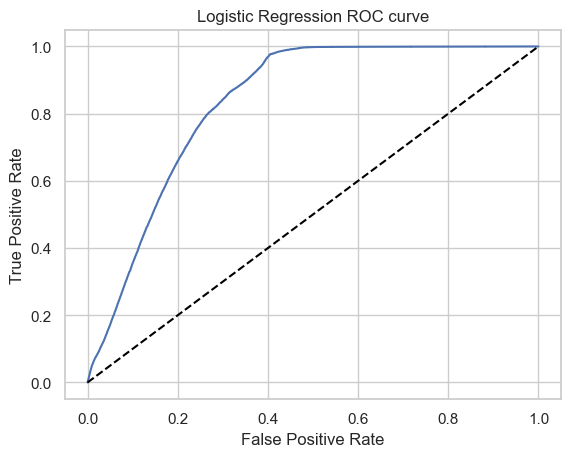

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, prob)

plt.title('Logistic Regression ROC curve')
plt.xlabel("False Positive Rate (Precision)")
plt.ylabel("True Positive Rate (Recall)")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

## Confusion Matrix

[[59655 40481]
 [ 2469 98035]]


<Axes: >

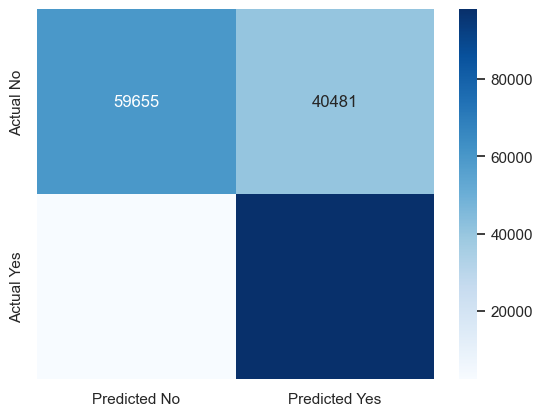

In [31]:
matrix= confusion_matrix(y_test, pred)
print(matrix)
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

In [32]:

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.60      0.96      0.74     62124
           1       0.98      0.71      0.82    138516

    accuracy                           0.79    200640
   macro avg       0.79      0.83      0.78    200640
weighted avg       0.86      0.79      0.79    200640



# Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest=randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
RF_probability = randomforest.predict_proba(X_test)[:,1]



AUC_RF=roc_auc_score(y_pred,y_test)
acc_rf=accuracy_score(y_test,y_pred)
recall_rf=recall_score(y_test,y_pred)
precision_rf=precision_score(y_test,y_pred)
f1score_rf=f1_score(y_test,y_pred)

print(accuracy_score(y_pred,y_test))
print("ROC_AUC Score:",AUC_RF)

0.9413427033492823
ROC_AUC Score: 0.9467904569605736


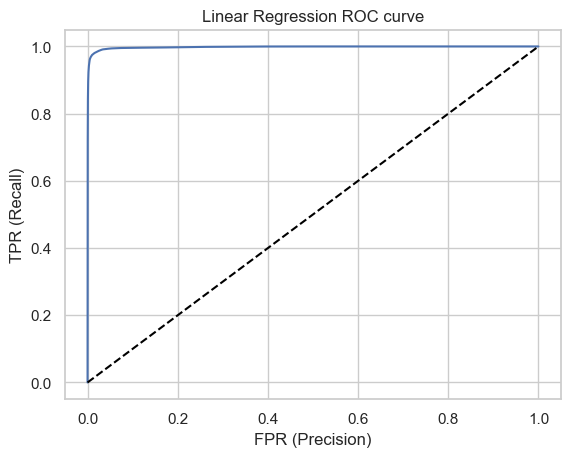

In [37]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, RF_probability)

plt.title('Random Forest ROC curve')
plt.xlabel('False Positive Rate (Precision)')
plt.ylabel('True Positive Rate (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()

<Axes: >

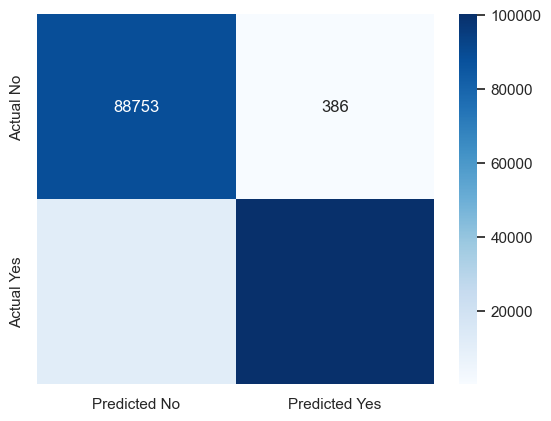

In [39]:
matrix2=confusion_matrix(y_pred,y_test)
sns.heatmap(matrix2, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

# Confrontiamo i due modelli

In [40]:
ind=['Logistic regression','Randomforest']
data={"Accuracy":[A_lgt,acc_rf],"Recall":[r_lgt,recall_rf],"Precision":[p_lgt,precision_rf],
    'f1_score':[f1_lgt,f1score_rf],"ROC_AUC":[acu_lgt,AUC_RF]}

result=pd.DataFrame(data=data,index=ind)
result

,Accuracy,Recall,Precision,f1_score,ROC_AUC
Logistic regression,0.785935,0.975434,0.707752,0.820308,0.834005
Randomforest,0.941343,0.996159,0.897911,0.944487,0.946790


Dal confronto dei due modelli possiamo notare come la RandomForest è migliore della Logistic Regression